# W207 Final Project Baseline: OpenBarbell

## 30 July 2018

### Project Description

OpenBarbell is a device that measures key lifting metrics during a lifter's workout. Example metrics are weight (user entry), peak velocity, and rep time (device captured). These metrics can be used by a lifter to better understand and improve their performance. The goal of this project is to use the data produced by OpenBarbell to add greater intelligence to the user experience.

### Project Goals

 1. *Exercise classification*. Exercise name is an open field (lifters can enter whatever they want or nothing at all). However, it is one of the key variables to analyze lifter performance. Hence, we would like to build an algorithm to determine exercise for each set based on its characteristics (weight, range of motion, velocity etc.)
 2. *Lifter segmentation*. Can we create distinct groups of lifters based on their lifting characteristics for each exercise (velocity, range of motion, weight)? This would help create semi-customized training programs.

### Data and Source

 - [OpenBarbell Data](https://github.com/squatsandsciencelabs/OpenBarbell-V3/wiki/OpenBarbell-Data-Storage-Format) - the dataset is provided by Squats and Science Barbell, no NDA is required per owner (Jordan Berke)
 - [Project GitHub Repository](https://github.com/YuliaZamriy/W207_Group_Project)

### Team
 - Renzee Reyes
 - Tim Witthoefft
 - Jack Workman
 - Yulia Zamriy
 
## Summary, Next Steps, and Open Questions at the Bottom

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import locale
import sys
import itertools
from locale import atof
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn import metrics

from scipy.stats import mode

%matplotlib inline

csv_data_file = 'ob_data_w207_filtered.csv'
zip_data_file = 'ob_data_w207_filtered.zip'

locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [3]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# 1. Import The Data

The data exists as a CSV encased in a zip file. Here, we unzip if not already unzipped and load the data file with pandas.

## 1.1 Note on CSV Data

The CSV data imported here is modified slightly from the original data source. The original data source is in JSON and contains 'deleted' or 'removed' observations that the devices recorded but the user did not want to retain. Since we do not know why the users deleted these rows (deletion could have been an accident, the user recognized the data was incorrect, etc), we have elected to not include these in our model.

Other data processing operations not seen in this notebook include:
- filtering exercises to "big 3" - squat, bench press, and deadlift
- converting certain fields from strings to datetime and numeric objects
- handle numbers with a comma as a decimal point
- converting 'weight' to lbs
- some outlier processing

The script used to do this pre-processing can be seen here: https://github.com/YuliaZamriy/W207_Group_Project/blob/master/OBDB_processing_v2.py

## 1.2 Import

In [4]:
df = None
if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
    zip_ref = zipfile.ZipFile(zip_data_file, 'r')
    zip_ref.extractall()
    zip_ref.close()
if os.path.exists(csv_data_file):
    df = pd.read_csv(csv_data_file)
    # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
    #df = pd.read_csv(csv_data_file, decimal='.')
else:
    raise Exception('Data file not found! {0}'.format(csv_data_file))

# 2. Quick EDA

To ensure that the data contains no hidden surprises, we do a quick EDA.

## 2.1 Shape and Head

In [5]:
print("Data shape: {0}".format(df.shape))

Data shape: (292910, 45)


In [6]:
df.head()

,_id,deleted,endTime,exercise,initialStartTime,metric,removed_set,rpe,setID,setNumber,startTime,tags,userID,videoFileURL,videoType,weight,workoutID,RepCount,isValid,removed_rep,hardware,appVersion,deviceName,deviceIdentifier,time,StartMessg,RepN,AvgVel,ROM,PeakVel,PeakVelLoc,StartData,RepDur,TimeBWReps,TimeRepComp,TimeRepWait,SlowAllow,Backlight,MinAllow,PeakAccel,_merge,rpe_num,weight_lbs,exercise_clean,exercise_clean2
0,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,0.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:46.902,-3456.0,11.0,0.258460,252.0,0.308408,37.0,NaN,978699.0,0.0,1.752134e+09,0.0,130000.0,10000.0,150000.0,11.073610,both,7.5,192.90425,bench,bench
1,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,1.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:49.526,-3456.0,12.0,0.273285,250.0,0.368293,72.0,NaN,915894.0,0.0,1.754801e+09,0.0,130000.0,10000.0,150000.0,0.714399,both,7.5,192.90425,bench,bench
2,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,2.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:52.272,-3456.0,13.0,0.268205,263.0,0.378763,72.0,NaN,983460.0,0.0,1.757625e+09,0.0,130000.0,10000.0,150000.0,0.730685,both,7.5,192.90425,bench,bench
3,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,3.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:55.633,-3456.0,14.0,0.268338,252.0,0.392775,72.0,NaN,942963.0,0.0,1.760793e+09,0.0,130000.0,10000.0,150000.0,0.923557,both,7.5,192.90425,bench,bench
4,000051e0-54b2-48d8-98d2-79f65505c3e6,NaN,NaN,Bench,2018-01-03 01:29:46.904,kgs,0.0,7.5,000051e0-54b2-48d8-98d2-79f65505c3e6,3.0,NaN,[],5a2e998b05cbc9b8ef26ac7e,assets-library://asset/asset.mov?id=CFFFFAC8-0...,lift,87.5,5bac5444-7c37-49d0-be8e-32be1a09fbb1,4.0,True,False,ios,3.2.3,OB 6666,709A15B7-B43C-AF0E-953A-6D4CEFEB4C83,2018-01-03 01:29:58.932,-3456.0,15.0,0.254381,250.0,0.389622,77.0,NaN,983978.0,0.0,1.764224e+09,0.0,130000.0,10000.0,150000.0,0.827607,both,7.5,192.90425,bench,bench


## 2.2 Check for Null Values

Here we observe that there are, in fact, quite a few null values in the dataset. Prior domain knowledge tells us that most of this is because the dataset is a combination of observations from multiple versions of the OpenBarbell platform and that older versions do not support some of the newer fields:

 - `endTime` and `startTime` replaced by `initialStartTime` and `time` in newer versions of the app
 - `PeakAccel` has been tracked since the latest app version (and this metric has some tracking issues)
 - `weight_lbs` (cleaned version of `weight`), `rpe_num` (cleaned version of `rpe`), `tags` are user's manual entries
 - `hardware`, `appVersion`, `deviceName`, `deviceIdentifier`, and `StartData` are hardware/software specific metrics not related to lifting
 - `videoFileURL` and `videoType` are place holder for user's videos

The majority of null values seen here can be safely ignored. However, some, like PeakAccel, will need to be handled. We do this in Section 3.

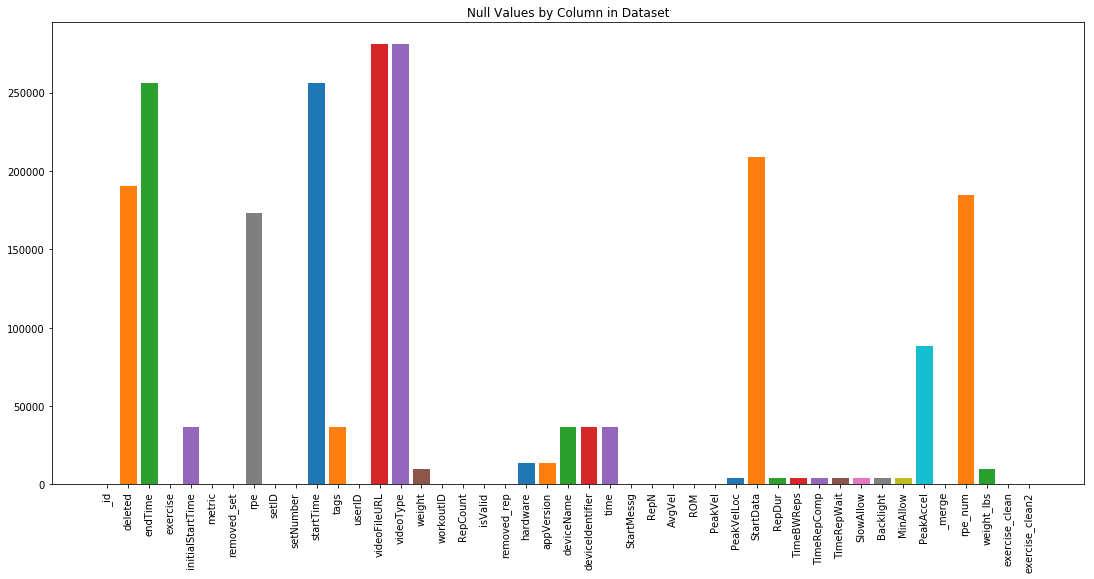

In [7]:
null_sums = df.isnull().sum()
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 8.5)
for i, null_col in enumerate(null_sums):
    plt.bar(i, null_col)

plt.title('Null Values by Column in Dataset')
plt.xticks(list(range(len(null_sums))), null_sums.index, rotation='vertical')
plt.show()

## 2.3 Target label variable

Our primary variable of interest is `exercise_clean`. As we can see based on table below, there are six possible values:

 - 3 *clean* values: **bench**, **deadlift**, **squat** where user entries for `exercise` were clean and specific 
 - 3 *other* values: **bench_other**, **deadlift_other**, **squat_other** where we had to perform `exercise` preprocessing to extract exercise name (it's possible that these capture variations of 3 main lifts)

In [8]:
def get_label_distribution(label):
    i, j = np.unique(label, return_counts = True)
    return pd.DataFrame({"Exercise": i, "Row count": j})
        
        
get_label_distribution(df['exercise_clean'])

,Exercise,Row count
0,bench,94640
1,bench other,35117
2,deadlift,35966
3,deadlift other,7366
4,squat,77680
5,squat other,42141


## 2.4 Analysis key features 

We are going to focus our analysis on the following set of features:

*Rep* specific:

 - `AvgVel`: Average velocity (m/s)
 - `ROM`: Range of motion (mm)
 - `PeakVel`: Peak Velocity (m/s) 
 - `PeakVelLoc`: Peak Velocity Location (%)
 - `PeakAccel`: Peak Acceleration (potentially drop as it has tracking issues)
 - `RepDur`: Duration of Rep (microseconds)

*Set* specific:

 - `weight_lbs`: weight (in lbs) for each set (user entry). Potentially exclude it from the analysis to reduce reliance on user inputs 

The following *rep* specific metrics have inconsistent data and are be dropped for now:
 - `TimeBWReps`: Time between Reps (minutes)
 - `TimeRepComp`: Timestamp of Rep Completion (microseconds)
 - `TimeRepWait`: Timestamp of time "waiting" in rep (microseconds)

In [9]:
df[['AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'weight_lbs']].describe()

,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,weight_lbs
count,292891.000000,292910.000000,292910.000000,288513.000000,2.885130e+05,283142.000000
mean,0.479184,462.061456,0.771857,72.132299,1.102977e+06,235.271909
std,0.223486,157.312786,0.377337,20.038203,4.745798e+05,105.251502
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.320720,326.000000,0.483974,65.000000,7.656250e+05,165.000000
50%,0.435733,450.000000,0.718287,79.000000,1.030670e+06,225.000000
75%,0.591369,598.000000,0.976293,87.000000,1.363892e+06,300.000000
max,2.960175,1761.000000,5.560000,99.000000,1.129953e+07,1000.000000


# 3. Clean and Feature Engineer the Data

## 3.1 Clean the Data

### TODO:

- consider removing 'weight_lbs' from the feature list as it's user input (hence, errors) and it doesn't really define exercise...

In [10]:
def clean_data(data, primary_label, features_to_keep, id_columns):
    """
    Cleans input dataset to
        1. keep only variables of interest
        2. drop nans 
        3. remove outliers
        4. split dataset into two parts (with 3 clean labels and 3 other labels)
    
    Args:
        data: pandas dataframe with all input data
        primary_label: string, target label variable name
        features_to_keep: list of strings, feature names to keep
        id_columns: list of strings, id names
    
    Returns:
        tuple of two dataframes
    """
    
    
    rows_before, cols_before = data.shape
    print(f"Dataset shape before cleaning: {data.shape}")
    
    # keep only the columns we care about
    data = data[[primary_label] + features_to_keep + id_columns]
    
    # drop rows with all zeros
    # doesn't really drop any rows because there are none with all zeroes
    # https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame
    # data.loc[(data!=0).any(1)]
    
    # remove rows that have 0s in at least one of the fields
    data = data.loc[data['AvgVel'] > 0]
    data = data.loc[data['PeakVelLoc'] > 0]
    # 1000 was max cap value in the pre-processing step
    data = data.loc[(data['weight_lbs'] > 0) & (data['weight_lbs'] < 1000)]
    
    # remove nulls
    data = data.dropna()
    rows_after, cols_after = data.shape
    
    print(f"{rows_before-rows_after} rows and {cols_before-cols_after} features were removed")
    # create a dataframe with 3 clean labels (primary training data)
    data_main = data.loc[data[primary_label].isin(["squat", "bench", "deadlift"])]
    print(f"Cleaned dataset shape with 3 clean labels: {data_main.shape}")
    # create a dataframe with 3 'other' labels (validation data)
    data_other = data.loc[~data[primary_label].isin(["squat", "bench", "deadlift"])]
    print(f"Cleaned dataset shape with 3 'dirty' labels: {data_other.shape}")
    
    print("\nDistribution of labels in main dataset:")
    print(get_label_distribution(data_main[primary_label]))
    print("\nDistribution of labels in other dataset:")
    print(get_label_distribution(data_other[primary_label]))
    
    return data_main, data_other

In [11]:
features_to_keep = ['AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'weight_lbs']
primary_label = 'exercise_clean'
id_columns = ['setID', 'RepCount']
df_main, df_other = clean_data(df, primary_label, features_to_keep, id_columns)

Dataset shape before cleaning: (292910, 45)
14591 rows and 36 features were removed
Cleaned dataset shape with 3 clean labels: (197798, 9)
Cleaned dataset shape with 3 'dirty' labels: (80521, 9)

Distribution of labels in main dataset:
   Exercise  Row count
0     bench      90323
1  deadlift      34371
2     squat      73104

Distribution of labels in other dataset:
         Exercise  Row count
0     bench other      33223
1  deadlift other       7151
2     squat other      40147


#### Main training dataset summary

In [12]:
df_main.describe()

,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,weight_lbs,RepCount
count,197798.000000,197798.000000,197798.000000,197798.000000,1.977980e+05,197798.000000,197798.000000
mean,0.465278,460.925171,0.752780,72.656260,1.137029e+06,237.990527,2.540607
std,0.221298,156.222555,0.366865,19.809925,4.847144e+05,105.507288,3.429876
min,0.039064,150.000000,0.034893,6.000000,7.135000e+04,1.000000,0.000000
25%,0.308179,323.000000,0.467492,66.000000,7.865910e+05,165.346500,1.000000
50%,0.419444,440.000000,0.701238,80.000000,1.072815e+06,225.000000,2.000000
75%,0.572467,597.000000,0.957379,87.000000,1.410157e+06,308.646800,3.000000
max,2.960175,1761.000000,5.560000,99.000000,6.072204e+06,970.032800,98.000000


#### Validation dataset summary

In [13]:
df_other.describe()

,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,weight_lbs,RepCount
count,80521.000000,80521.000000,80521.000000,80521.000000,8.052100e+04,80521.000000,80521.000000
mean,0.499619,461.813353,0.792300,71.254654,1.035526e+06,225.786265,2.863328
std,0.215058,155.034216,0.375286,20.495366,4.378159e+05,98.325651,3.615174
min,0.054124,150.000000,0.020000,7.000000,1.029050e+05,0.160000,0.000000
25%,0.350657,334.000000,0.517039,63.000000,7.407840e+05,155.000000,1.000000
50%,0.465511,461.000000,0.739107,79.000000,9.586180e+05,215.000000,2.000000
75%,0.608149,592.000000,0.981582,86.000000,1.255585e+06,275.577500,4.000000
max,2.667038,1687.000000,4.740000,99.000000,1.129953e+07,970.032800,49.000000


## 3.2 Factorize target variable

In [14]:
def factorize_label(label):
    """
    Factorizes string variable
    
    Args:
        label: array of string labels
    
    Returns:
        tuple: (array of numeric labels, list of unique label names) 
    """
    
    return pd.factorize(label, sort=True)


# creating primary target label array
labels_main_num, labels_main_names = factorize_label(df_main[primary_label])
print(labels_main_names)
get_label_distribution(labels_main_num)

Index(['bench', 'deadlift', 'squat'], dtype='object')


,Exercise,Row count
0,0,90323
1,1,34371
2,2,73104


In [15]:
# creating validation target label array
labels_other_num, labels_other_names = factorize_label(df_other[primary_label])
print(labels_other_names)
get_label_distribution(labels_other_num)

Index(['bench other', 'deadlift other', 'squat other'], dtype='object')


,Exercise,Row count
0,0,33223
1,1,7151
2,2,40147


## 3.3 Feature Engineering

Todo!

In [16]:
def feature_engineer_data(data):
    # todo
    return data

#### Remove target and id variables from feature dataset

In [17]:
df_main = df_main.drop(primary_label, axis=1)
df_other = df_other.drop(primary_label, axis=1)

# 4. Separate Data Into Train, Dev, & Test Sets

For this project, we are splitting the dataset into the following three categories:
1. Train - 80%
2. Dev - 10%
3. Test - 10%

Train will be used to train the model. We will use Dev to test our pipeline and model modifications. We will use Test as a final checkpoint of model performance.


## 4.1 Shuffle main dataset

### TODO: do we need this step given that partition_data (see below) also does random split?

In [18]:
# Shuffle the input: create a random permutation of the integers between 0 
# and the number of data points and apply this permutation to features and targets
# NOTE: Set random seed to ensure replication of the process
np.random.seed(10)
shuffle = np.random.permutation(np.arange(df_main.shape[0]))
df_main, labels_main_num = df_main.iloc[shuffle], labels_main_num[shuffle]

print('data shape: ', df_main.shape)
print('label numeric shape:', labels_main_num.shape)

data shape:  (197798, 8)
label numeric shape: (197798,)


## 4.2 Partition main dataset

### TODO:

- Unique idenitifiers: `setID` and `RepCount`. Should we split dataset by `setID` so that reps that belong to the same set get into the same split?

In [19]:
def partition_data(data, labels, dev_pct, test_pct, seed):
    """
    Partitions input dataset into training, development and testing 
    
    Args:
        data: feature dataset
        labels: array of target labels
        dev_pct: float, percent of data to allocate to development
        test_pct: float, percent of data to allocate to testing
        seed: int, random seed
        
    Returns:
        6-tuple with 3 feature datasets and 3 target label arrays
    """
    
    
    train_data, nontrain_data, train_labels, nontrain_labels = train_test_split(data
                                                                                , labels
                                                                                , test_size=dev_pct + test_pct
                                                                                , random_state=seed)
    
    test_data, dev_data, test_labels, dev_labels = train_test_split(nontrain_data
                                                                    , nontrain_labels
                                                                    , test_size=dev_pct/(dev_pct + test_pct)
                                                                    , random_state=seed)
    
    return train_data, test_data, dev_data, train_labels, test_labels, dev_labels


train_data, test_data, dev_data, train_labels, test_labels, dev_labels = partition_data(df_main, labels_main_num, .1, .1, 5)

print(f'Dev data & labels shapes: {dev_data.shape}, {dev_labels.shape}')
print(f'Test data & labels shapes: {test_data.shape}, {test_labels.shape}')
print(f'Train data & labels shapes: {train_data.shape}, {train_labels.shape}')

Dev data & labels shapes: (19780, 8), (19780,)
Test data & labels shapes: (19780, 8), (19780,)
Train data & labels shapes: (158238, 8), (158238,)


## 4.3 Standardize training dataset

In [20]:
def standardize_data(data_fit, data_transform):
    """
    Standardize input dataset and apply it to the second input dataset
    
    Args:
        data_fit: feature dataset used to fit standardization
        data_transform: feature dataset to apply standardization to
    
    Returns:
        standardized dataset
    """
    
    scaler = preprocessing.StandardScaler().fit(data_fit)
    data_std = scaler.transform(data_transform)
    print(f"\nMeans of standardized features: {np.around(np.mean(data_std, axis = 0),2)}")
    print(f"STDV of transform features: {np.around(np.std(data_std, axis = 0),2)}")
    return data_std


# first need to remove id columns since they are not features
train_data_noids = train_data.drop(id_columns, axis = 1)
dev_data_noids = dev_data.drop(id_columns, axis = 1)
test_data_noids = test_data.drop(id_columns, axis = 1)
df_other_noids = df_other.drop(id_columns, axis = 1)
train_data_std = standardize_data(train_data_noids, train_data_noids)
dev_data_std = standardize_data(train_data_noids, dev_data_noids)
test_data_std = standardize_data(train_data_noids, test_data_noids)
df_other_std = standardize_data(train_data_noids, df_other_noids)


Means of standardized features: [ 0. -0. -0.  0.  0. -0.]
STDV of transform features: [ 1.  1.  1.  1.  1.  1.]

Means of standardized features: [-0.  0.  0. -0.  0.  0.]
STDV of transform features: [ 0.99  1.    0.99  1.    1.    1.01]

Means of standardized features: [-0.   -0.01 -0.   -0.01 -0.01 -0.  ]
STDV of transform features: [ 1.    0.99  0.99  1.01  0.99  1.  ]

Means of standardized features: [ 0.15  0.01  0.11 -0.07 -0.21 -0.12]
STDV of transform features: [ 0.97  0.99  1.02  1.04  0.9   0.93]


# 5. Train and Test the Model

## 5.1 Define general function for classfication

### TODO:

 - adjust `argv` to make it more general

In [21]:
def make_classifier(classifier, train, train_labs, dev, dev_labs, lab_names, printout, *argv):
    
    
    if argv:
        clsf = classifier(argv[0])
        print(f"\nResults for key parameter value = {argv[0]}")
    else:
        clsf = classifier()
    clsf.fit(train, train_labs)
    pred_labs = clsf.predict(dev)
    print(f"Accuracy on non-training data: {clsf.score(dev, dev_labs)*100:.2f}%")
    
    if printout == True:
        get_performance(dev_labs, pred_labs, lab_names)
    
    return pred_labs

In [22]:
# borrowed from scikit learn tutorial
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

np.set_printoptions(precision=2)

def plot_confusion_matrix(true_labs, pred_labs,
                          lab_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    cm = confusion_matrix(true_labs, pred_labs)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(lab_names))
    plt.xticks(tick_marks, lab_names, rotation=45)
    plt.yticks(tick_marks, lab_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [23]:
def get_performance(true_labs, pred_labs, lab_names):

    print("="*50)
    print("Classification report by exercise:")
    print(classification_report(true_labs, pred_labs, target_names=lab_names))
    print("="*50)
    print("Confusion matrix:")
    print(pd.DataFrame(confusion_matrix(true_labs, pred_labs), columns=lab_names, index=lab_names))
    plot_confusion_matrix(true_labs, pred_labs, lab_names, normalize=True, title='Normalized Confusion Matrix')

## 5.2 KNN

**Key findings**:

 - It appears that k value doesn't really matter
 - Validates well on development dataset with clean labels
 - Drops 10 points in accuracy on other data
 - Deadlift classification is an issue, especially on the "other" data

### 5.2.1 What k to use?

In [24]:
for k in range(1, 11):
    make_classifier(KNeighborsClassifier, train_data_std, train_labels, dev_data_std, dev_labels, labels_main_names, False, k)


Results for key parameter value = 1
Accuracy on non-training data: 94.95%

Results for key parameter value = 2
Accuracy on non-training data: 94.68%

Results for key parameter value = 3
Accuracy on non-training data: 95.45%

Results for key parameter value = 4
Accuracy on non-training data: 95.35%

Results for key parameter value = 5
Accuracy on non-training data: 95.62%

Results for key parameter value = 6
Accuracy on non-training data: 95.55%

Results for key parameter value = 7
Accuracy on non-training data: 95.65%

Results for key parameter value = 8
Accuracy on non-training data: 95.58%

Results for key parameter value = 9
Accuracy on non-training data: 95.56%

Results for key parameter value = 10
Accuracy on non-training data: 95.49%


### 5.2.2 Train the model with k = 1


Results for key parameter value = 1
Accuracy on non-training data: 94.95%
Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.98      0.98      0.98      9003
   deadlift       0.89      0.88      0.89      3430
      squat       0.94      0.94      0.94      7347

avg / total       0.95      0.95      0.95     19780

Confusion matrix:
          bench  deadlift  squat
bench      8830        65    108
deadlift     85      3033    312
squat       122       306   6919


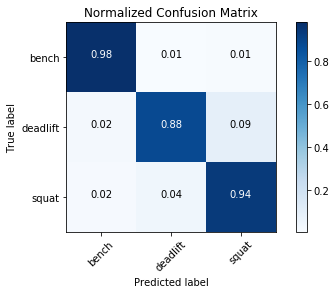

In [25]:
knn_dev_prediciton = make_classifier(KNeighborsClassifier, train_data_std, train_labels, dev_data_std, dev_labels, labels_main_names, True, 1)

### 5.2.3 Check performance on "other" labels


Results for key parameter value = 1
Accuracy on non-training data: 85.13%
Classification report by exercise:
                precision    recall  f1-score   support

   bench other       0.90      0.95      0.92     33223
deadlift other       0.47      0.72      0.57      7151
   squat other       0.92      0.79      0.85     40147

   avg / total       0.87      0.85      0.86     80521

Confusion matrix:
                bench other  deadlift other  squat other
bench other           31607             531         1085
deadlift other          345            5147         1659
squat other            3193            5160        31794


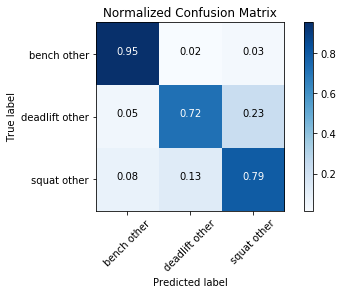

In [26]:
knn_other_prediction = make_classifier(KNeighborsClassifier, train_data_std, train_labels, df_other_std, labels_other_num, labels_other_names, True, 1)

## 5.3 Gaussian NB

**Key findings**:

 - Lower accuracy of development data compared to KNN
 - Poor performance for deadlift classification
 - No drop in accuracy on "other" data (same accuracy as in KNN)
 - But dealift accuracy is still lagging

### 5.3.1 Model without any customization and validate on development data

Accuracy on non-training data: 87.32%
Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.92      0.97      0.94      9003
   deadlift       0.85      0.53      0.65      3430
      squat       0.82      0.92      0.87      7347

avg / total       0.87      0.87      0.87     19780

Confusion matrix:
          bench  deadlift  squat
bench      8690        49    264
deadlift    433      1817   1180
squat       317       266   6764


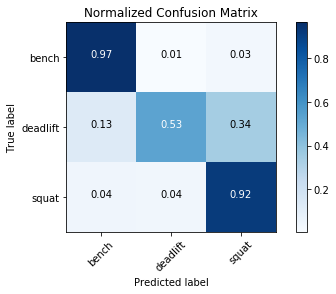

In [27]:
gnb_dev_predictions = make_classifier(GaussianNB, train_data_std, train_labels, dev_data_std, dev_labels, labels_main_names, True)

### 5.3.2 Model performance on "other" labels

Accuracy on non-training data: 87.10%
Classification report by exercise:
                precision    recall  f1-score   support

   bench other       0.90      0.97      0.93     33223
deadlift other       0.54      0.74      0.62      7151
   squat other       0.94      0.81      0.87     40147

   avg / total       0.89      0.87      0.87     80521

Confusion matrix:
                bench other  deadlift other  squat other
bench other           32259             304          660
deadlift other          342            5281         1528
squat other            3297            4257        32593


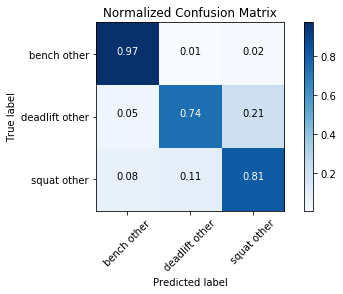

In [28]:
gnb_other_prediction = make_classifier(KNeighborsClassifier, train_data_std, train_labels, df_other_std, labels_other_num, labels_other_names, True)

## 5.4 Decision Trees

### 5.4.1 Model formation

**Key findings**:

 - Good model performance on development data
 - Deadlift classification again is lagging in accuracy
 - Most of the confusion is between squat and deadlift

Internal notes on code modifications:

 - removed `imputer` from the pipeline because we have already preprocessed the data
 - removed `PCA` because we don't have that many features
 - switched to `accuracy` instead of `f1` to remain consistent with the rest of the dataset
 - removed `classes` because `labels_main_names` captures the same labels

### TODO:

 - We've already scaled the data above. Should we (1) incorporate `pipeline` for the above classification methods? or (2) remove it from here and replace with `make_classifier` function?
 - Output best parameter for random forest

In [29]:
pipeline = Pipeline(steps=[
    ('scale', preprocessing.StandardScaler()),
    ('randomforest', RandomForestClassifier())])

parameters = {
    "randomforest__n_estimators":[2,4,6,8],
}

accuracy = metrics.make_scorer(metrics.accuracy_score)
grid_search = GridSearchCV(pipeline, parameters, scoring=accuracy)
grid_search.fit(train_data_noids, train_labels)
rf_dev_predictions = grid_search.predict(dev_data_noids)

### 5.4.2 Model evaluation on development data

Accuracy on development data: 95.30%
Classification report by exercise:
             precision    recall  f1-score   support

      bench       0.97      0.99      0.98      9003
   deadlift       0.90      0.89      0.89      3430
      squat       0.95      0.94      0.95      7347

avg / total       0.95      0.95      0.95     19780

Confusion matrix:
          bench  deadlift  squat
bench      8898        45     60
deadlift    110      3051    269
squat       138       307   6902


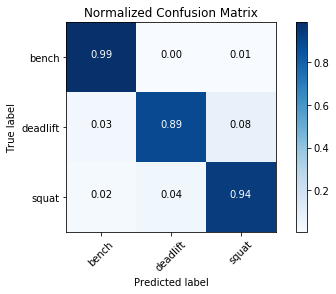

In [30]:
print(f"Accuracy on development data: {grid_search.score(dev_data_noids, dev_labels)*100:.2f}%")
get_performance(dev_labels, rf_dev_predictions, labels_main_names)

### 5.4.3 Model performance on "other" labels

Accuracy on testing data: 87.06%
Classification report by exercise:
                precision    recall  f1-score   support

   bench other       0.89      0.98      0.93     33223
deadlift other       0.54      0.73      0.62      7151
   squat other       0.94      0.81      0.87     40147

   avg / total       0.88      0.87      0.87     80521

Confusion matrix:
                bench other  deadlift other  squat other
bench other           32436             251          536
deadlift other          401            5242         1508
squat other            3565            4161        32421


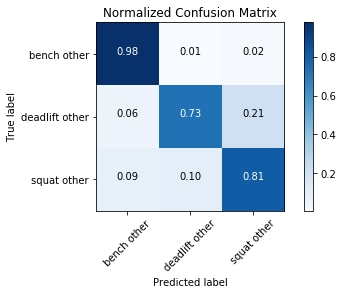

In [31]:
rf_other_predictions = grid_search.predict(df_other_noids)
print(f"Accuracy on testing data: {grid_search.score(df_other_noids, labels_other_num)*100:.2f}%")
get_performance(labels_other_num, rf_other_predictions, labels_other_names)

# 6. Post-Model Custom Logic

As well as optimizing model hyper-parameters, we can also apply custom logic after the final classification. For example, we can implement custom ensemble logic, similar to the random forest algorithm, to ensure reps within the same set are classified similarly.

### TODO: 
 
 - modify the below function to accept two ID columns (setID and RepCount)

In [32]:
def set_ensemble_consensus(predictions, set_ids):
    consensus_pred = predictions
    
    for i, setID in enumerate(set_ids):
        set_ix = [i for i in range(len(set_ids)) if set_ids[i] == setID]
        set_pred_mode = mode(consensus_pred[set_ix])[0][0]
        consensus_pred[i] = set_pred_mode
        
    return consensus_pred


# consensus_pred = set_ensemble_consensus(knn_test_prediciton, test_data['setID'].tolist())
# correct_ct = 0
# for i, prediction in enumerate(consensus_pred):
#     if prediction == test_labels.iloc[i]:
#         correct_ct += 1
    
# print("Ensemble Accuracy: ", correct_ct / test_labels.size)

# Summary

Our group has successfully put together a pipeline where we can rapidly iterate on improving our model. The remaining time before submission will be spent analyzing, iterating, and improving our model's performance.

# Next Steps

- Continue analyzing the data to improve cleaning and feature engineering
- Explore the reasons for poor deadlift classification
- Explore additional machine learning algorithms to determine which is best for this dataset and problem
- Develop a more robust method of scoring performance to guide what needs to be improved in the pipeline and model
- Apply ensemble logic to selected algorithms
- Apply an unsupervised algorithm for Goal #2: Lifter Segmentation

# Open Questions

- What model algorithm gives the best performance and why?
- Do we need to build a separate model for Big 3 lifts with "other" label? 
- What's the best way to handle null values? 
- How should we treat outliers?